# Spectogram Dataset

## Dataset

Here we create the dataset

In [1]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from utils.custom_datasets import *  
from utils.utils_functions import *

In [2]:
# Path to the csv file with the features
features_file = 'Data/features_30_sec.csv'
img_dir = 'Data/images_original'

### Custom Transformations for the dataset


Here we create some custom trasnformation for our dataset


In [3]:
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']
# Example usage of the transform
label_transform = LabelTransform(labels)

Here we instantiate the actual transformations


In [4]:
# Example usage of the transform
label_transform = LabelTransform(labels)


# This transform also normalizes
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.466],            
                         std=[0.459])        # We just center the data, no normalization
])

Here we are creating the training and test dataset


In [5]:
# Create the dataset
gtzan_dataset = GTZANSpectogramDataset(features_file=features_file, img_dir=img_dir, transform=transform_norm, target_transform=label_transform)
# Split the dataset into training and test sets
training_data, test_data = torch.utils.data.random_split(gtzan_dataset, [800, 200])

# Create data loaders
batch_size = 50
shuffle = True
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=shuffle)         # Each element in the dataloader iterable will return a batch of 64 features and labels.
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle) 

## Creating the Model


To build this model we used the official pytorch tutorials


In the original paper the convolution block were directly fed into the output layer, we added a global average pooling layer to help in performing classification

In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


# Define model
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Input layer is defined implicitly by the input size of the first convolutional layer
        
        # Convolutional blocks
        self.conv_layers = nn.Sequential(
            # Block 1: Conv -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            # Block 2: Conv -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            # Block 3: Conv -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            # Block 4: Conv -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            # Block 5: Conv -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            # Global Avg Pooling
            nn.Conv2d(in_channels=256, out_channels=10, kernel_size=1),
            nn.AdaptiveAvgPool2d((1, 1)),            # This calculates autmatically the dimensions for the kernel in global avg pooling
            
            # Flattening for the output
            nn.Flatten()
        
        )
        

        
    def forward(self, x):
        logits = self.conv_layers(x)     
        return logits
    

# Our model
model = ConvNet().to(device)
print(model)

Using cuda device
ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.2, inplace=False)
    (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (17): ReLU

## Training the model


Here we choose the optimizers


In [7]:
loss_fn = nn.CrossEntropyLoss()                            # This performs softmax automatically
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

Training process

Epoch 1
loss: 2.305857
-------------------------------
Epoch 2
loss: 2.289714
-------------------------------
Epoch 3
loss: 2.309402
-------------------------------
Epoch 4
loss: 2.296978
-------------------------------
Epoch 5
loss: 2.271211
-------------------------------
Epoch 6
loss: 2.226501
-------------------------------
Epoch 7
loss: 2.138030
-------------------------------
Epoch 8
loss: 2.052654
-------------------------------
Epoch 9
loss: 2.129167
-------------------------------
Epoch 10
loss: 2.114661
-------------------------------
Epoch 11
loss: 1.952508
-------------------------------
Epoch 12
loss: 2.264485
-------------------------------
Epoch 13
loss: 2.046680
-------------------------------
Epoch 14
loss: 2.018311
-------------------------------
Epoch 15
loss: 1.834890
-------------------------------
Epoch 16
loss: 1.957726
-------------------------------
Epoch 17
loss: 2.071852
-------------------------------
Epoch 18
loss: 2.118651
-------------------------------
E

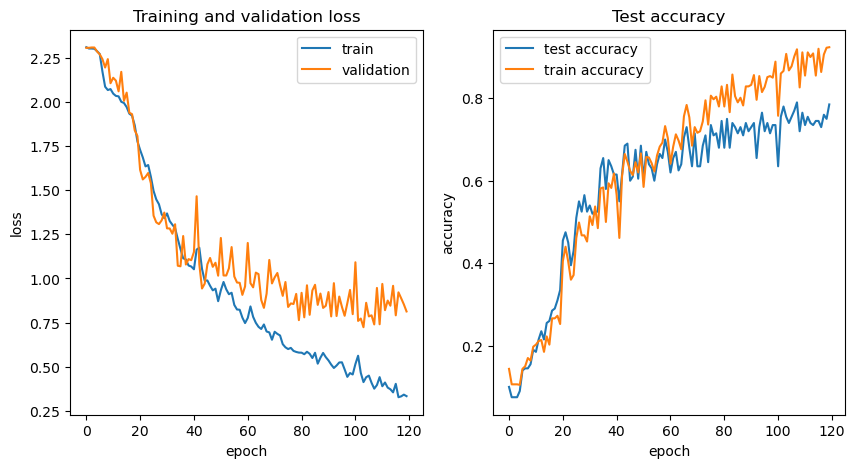

In [8]:
epochs = 120

# Histories
train_history = list()
validation_history = list()
accuracy_test_history = list()
accuracy_train_history = list()

# Training loop
for t in range(epochs):
    print(f"Epoch {t+1}")
    train_loss = train(train_dataloader, model, loss_fn, optimizer, device)
    validation_loss = test_loss(test_dataloader, model, loss_fn, device)


    train_history.append(train_loss)
    validation_history.append(validation_loss)
    accuracy_test_history.append(test_accuracy(test_dataloader, model, device))
    accuracy_train_history.append(test_accuracy(train_dataloader, model, device))
    print("-------------------------------")
    
print("Done!")

print(f"{test_accuracy(test_dataloader, model, device)*100:.2f}%")


# Plots
fig, axs = plt.subplots(1,2, figsize=(10, 5))

# Training and validation loss
axs[0].plot(train_history, label = 'train')
axs[0].plot(validation_history, label = 'validation')
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("loss")
axs[0].set_title("Training and validation loss")
axs[0].legend()

# Accuracy
axs[1].plot(accuracy_test_history, label = 'test accuracy')
axs[1].plot(accuracy_train_history, label = 'train accuracy')
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("accuracy")
axs[1].set_title("Test accuracy")
axs[1].legend()

# Saving the models

This code saves the full model:

In [9]:
torch.save(model, 'models/model_weights_conv.pth')

To Load and use the model do:

In [10]:
#model = torch.load('models\\model_weights_conv.pth')
#model.eval()  # Set the model to evaluation mode